# Driver Behavior Cloning

## Goal
We'll be using deep neural network approach in order to mimic human driving behavior. The general idea here is to gather training data by driving the car in simulator, then train the deep neural network with that data, and in the end let the car be driven by the model generated by the deep neural network.

![Screenshot from Udacity's self driving car simulator](https://media.githubusercontent.com/media/udacity/self-driving-car-sim/master/sim_image.png)

We shall be using Udacity's self driving car simulator for the same. It can be downloaded from [GitHub](https://github.com/udacity/self-driving-car-sim).

## Downloading the training data
The training dataset can be built by running the simulator in *Training Mode*, while keeping the recording ON.

Downloading pre-recorded data...

In [0]:
! git clone https://github.com/pratikgujral/Self-Driving-Car
!ls

fatal: destination path 'Self-Driving-Car' already exists and is not an empty directory.
model.h5  sample_data  Self-Driving-Car  track


## Importing the required libraries

In [0]:
import numpy as np
# For plotting graphs and displaying images
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
# For preparing training dataset
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
import cv2 #OpenCV

# For building the DL model
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

import pandas as pd
import zipfile
import random
import ntpath
import os
%tensorflow_version 1.x # Magic command to prevent (Colab) notebook for using Tensorflow 2.x

Using TensorFlow backend.


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # Magic command to prevent (Colab) notebook for using Tensorflow 2.x`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


## Reading and exploring the dataset

In [0]:
datadir = 'Self-Driving-Car/Behavioral-Cloning/dataset'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\pratikgujral\dataset\IMG\center_2018_07_16_...,D:\pratikgujral\dataset\IMG\left_2018_07_16_17...,D:\pratikgujral\dataset\IMG\right_2018_07_16_1...,0.0,0.0,0.0,0.649786
1,D:\pratikgujral\dataset\IMG\center_2018_07_16_...,D:\pratikgujral\dataset\IMG\left_2018_07_16_17...,D:\pratikgujral\dataset\IMG\right_2018_07_16_1...,0.0,0.0,0.0,0.627942
2,D:\pratikgujral\dataset\IMG\center_2018_07_16_...,D:\pratikgujral\dataset\IMG\left_2018_07_16_17...,D:\pratikgujral\dataset\IMG\right_2018_07_16_1...,0.0,0.0,0.0,0.622910
3,D:\pratikgujral\dataset\IMG\center_2018_07_16_...,D:\pratikgujral\dataset\IMG\left_2018_07_16_17...,D:\pratikgujral\dataset\IMG\right_2018_07_16_1...,0.0,0.0,0.0,0.619162
4,D:\pratikgujral\dataset\IMG\center_2018_07_16_...,D:\pratikgujral\dataset\IMG\left_2018_07_16_17...,D:\pratikgujral\dataset\IMG\right_2018_07_16_1...,0.0,0.0,0.0,0.615438


To find out the size of the dataset available, we can simply count the number of rows in the `DataFrame` by calling `len(..)` function on it.

In [0]:
print('Length of data:', len(data))

Length of data: 4053


The recorded driving log in the CSV has complete(absolute) file paths to images, which is not required for us. So pruning the path to only keep the filename, we'll use the `ntpath` library imported earlier.

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

Printing out a sample path from the `DataFrame` as it appears before pruning.

In [0]:
print(data['center'][0])

D:\pratikgujral\dataset\IMG\center_2018_07_16_17_11_43_382.jpg


Printing out the same sample path from the `DataFrame` after pruning the absolute path to only keep the file name.

In [0]:
temp_tail = path_leaf(data['center'][0])
print('TAIL:', temp_tail)

TAIL: center_2018_07_16_17_11_43_382.jpg


So having confirmed that our `path_leaf( )` function works as intended, we'll go ahead and apply it to the driving log `DataFrame`.

In [0]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [0]:
# Visualizing the distribution of our dataset

num_bins = 25 # odd number so that we have a center value

hist, bins = np.histogram(data['steering'], bins = num_bins)
print(bins) 

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


**NOTE** that the values of the bins go from -1 to 1. This is the range of values our steering value column takes. However, the values are not zero-centred, that is, we don't have a '0' in the `bins` we printed.

Hence, in order to zero-center the bins:

In [0]:
center = (bins[ : -1] + bins[1 : ]) / 2
print(center)

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


### Plotting the bar graph

<BarContainer object of 25 artists>

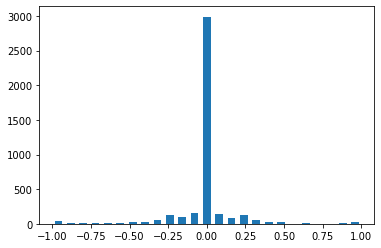

In [0]:
plt.bar(x = center, height = hist, width = 0.05)

So our steering values go from -1 to +1, centered around 0.

As we can see, we have a lot more values at steering angle '0'. This is because for most of the part of the track was straight. However, this is a problem of data imbalance and would cause our neural network to be biased towards predicting this value more often.

To counter this problem, we are going to scrap some rows corresponding to steering angle 0 to make the data more balanced.

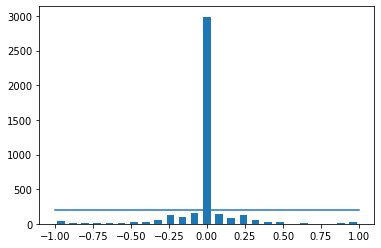

In [0]:
samples_per_bin = 200

#Again plotting the same bar chart as above, and additionally plotting a line at 250 samples
plt.bar(x = center, height = hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

As evident, if we only keep `samples_per_bin` number of samples for the steering angle 0, we'd get a relatively more uniform distribution- implying that our dataset would be more balanced than it was previously.

In [0]:
num_bins

25

In [0]:
remove_list = [] #We'd add rows info to this list that we'd eventually renmove from our dataset

print('Length of data before we remove extra samples:', len(data))

for j in range(num_bins):
  list_ = []
  for i in range(len(data)):
    if (data['steering'][i] >= bins[j]) and (data['steering'][i] <= bins[j+1]):
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin : ] # Remove all elements beyond samples_per_bin
  remove_list.extend(list_)

print('# of steering angles removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Length of data after removing extra samples:', len(data))

Length of data before we remove extra samples: 4053
# of steering angles removed 2790
Length of data after removing extra samples: 1263


In [0]:
hist, _ = np.histogram(data['steering'], bins=num_bins)

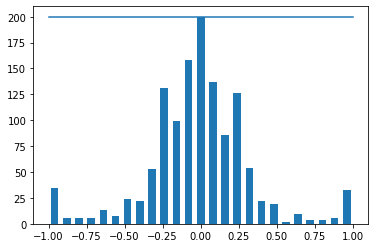

In [0]:
#Again plotting the same bar chart as above, and  plotting a line at 250 samples
plt.bar(x = center, height = hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

## Preparing training, validation and test data

In [0]:
print(data.iloc[0])

center      center_2018_07_16_17_11_44_137.jpg
left          left_2018_07_16_17_11_44_137.jpg
right        right_2018_07_16_17_11_44_137.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                                  0.59835
Name: 8, dtype: object


In [0]:
def load_steering_images(datadir, df):
  image_path = []
  steering = []

  for i in range(len(data)):
    indexed_data = data.iloc[i] # Grab a row from the data DataFrame
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)

  return image_paths, steerings

In [0]:
image_paths, steerings = load_steering_images(datadir + '/IMG', data)

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [0]:
print('Training samples: {} \nValidation samples: {}'.format(len(X_train), len(X_val)))

Training samples: 1010 
Validation samples: 253


Text(0.5, 1.0, 'Validation set')

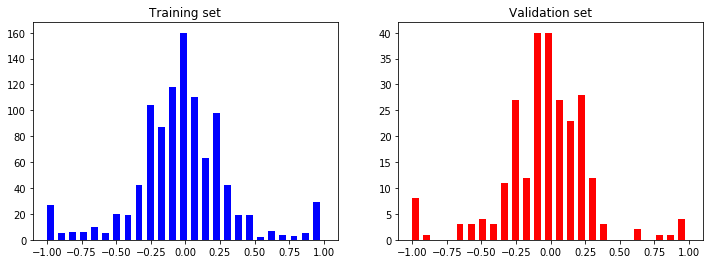

In [0]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_val, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

As evident from the above histograms- both training and validation datasets are symmetrical about the '0' steering angle, which is actually what we want to be able to train an un-biased classfier/regressor.

In [0]:
def img_preprocess(img_path):
  # Read the image
  img = mpimg.imread(img_path)
  # Focussing only on the road and cropping the sky, trees, car's hood part by Numpy slicing
  img = img[ 60:135, : , :]
  
  # converting images to YUV colorspace
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # Y-Luminosity/Brightness, UV-colors
  
  # Applying Gaussian blur
  img = cv2.GaussianBlur(img, (3,3), 0)
  
  # Resizing the images
  img = cv2.resize(img, (200,66))
  
  # normalization
  img = img/255.
  return img

Text(0.5, 1, 'Preprocessed Image')

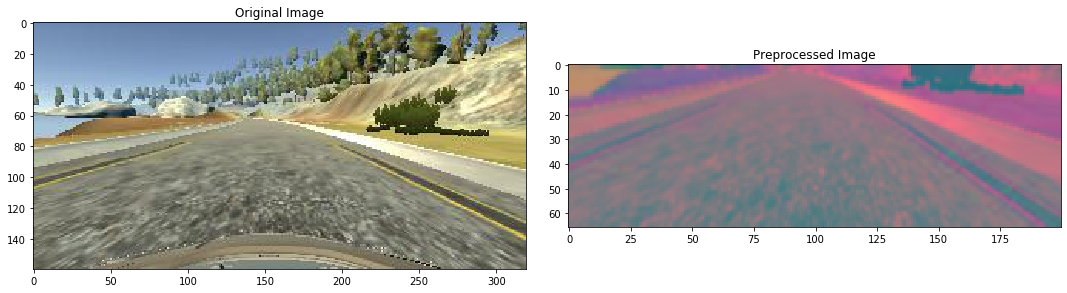

In [0]:
img = image_paths[100]
original_image = mpimg.imread(img)
preprocessed_image = img_preprocess(img)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

### Applying the preprocessing to the training and validation dataset

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_val = np.array(list(map(img_preprocess, X_val)))

(1010, 66, 200, 3)


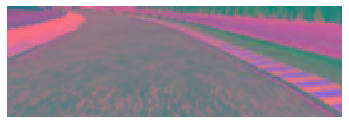

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

## Defining the model

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5,5), strides=(2,2), input_shape=(66,200,3), activation='relu'))
  model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, (5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Dropout(rate=0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(rate=0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(rate=0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(rate=0.5))
  
  model.add(Dense(1))
  
  model.compile(loss='mse', optimizer=Adam(lr=1e-3))
  
  return model

In [0]:
model = nvidia_model()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [0]:
history = model.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val), batch_size=64, verbose=1, shuffle=1)




Train on 1010 samples, validate on 253 samples
Epoch 1/40





1010/1010 [==============================] - 4s 4ms/step - loss: 0.4656 - val_loss: 0.1091
Epoch 2/40
1010/1010 [==============================] - 0s 458us/step - loss: 0.1529 - val_loss: 0.0943
Epoch 3/40
1010/1010 [==============================] - 0s 448us/step - loss: 0.1265 - val_loss: 0.0913
Epoch 4/40
1010/1010 [==============================] - 0s 458us/step - loss: 0.1214 - val_loss: 0.0877
Epoch 5/40
1010/1010 [==============================] - 0s 444us/step - loss: 0.1179 - val_loss: 0.0804
Epoch 6/40
1010/1010 [==============================] - 0s 464us/step - loss: 0.1145 - val_loss: 0.0732
Epoch 7/40
1010/1010 [==============================] - 0s 452us/step - loss: 0.0971 - val_loss: 0.0584
Epoch 8/40
1010/1010 [==============================] - 0s 463us/step - loss: 0.0902 - val_loss: 0.0560
Epoch 9/40
1010/1010 [==============================] - 0s 451us/step - loss: 0.0979 - val_loss: 0.0529
Epoch 10/40

Text(0.5, 1.0, 'Loss')

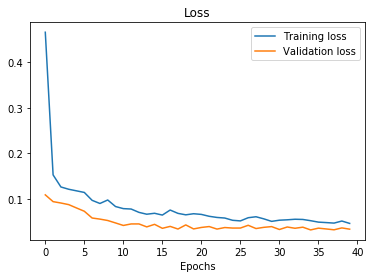

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'])
plt.title('Loss')

In [0]:
model.save('model.h5')

## Downloading the saved model to file system

In [0]:
from google.colab.files import download
download('model.h5')